# Setup

In [1]:
import json
import os

if os.path.basename(os.getcwd()) != "situational-awareness":
    # move up two directories
    os.chdir("../..")

import random
from typing import Tuple
import numpy as np
import pandas as pd
import wandb

from src.common import flatten, load_from_jsonl, save_to_jsonl
from src.models.openai_complete import OpenAIAPI
from src.wandb_utils import convert_runs_to_df
from tqdm import tqdm
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
import functools

from src.tasks.reverse_experiments.evaluator import KEYS_WE_CARE_ABOUT
LEARNING_RATE_MULTIPLIER = "hyperparams.learning_rate_multiplier"
BATCH_SIZE = "hyperparams.batch_size"
CONFIGS_WE_CARE_ABOUT = ["model", "fine_tuned_model", LEARNING_RATE_MULTIPLIER, BATCH_SIZE]

/Users/lukasberglund/opt/anaconda3/envs/py10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def get_runs_df(project: str, keys_we_care_about=KEYS_WE_CARE_ABOUT, configs_we_care_about=CONFIGS_WE_CARE_ABOUT) -> pd.DataFrame:
    """Get a dataframe of the runs in a project."""
    api = wandb.Api()
    runs = api.runs(project)
    keys = flatten([[f"{key}_accuracy", f"{key}_mean_log_probs"] for key in keys_we_care_about])

    return convert_runs_to_df(runs, keys, configs_we_care_about)

runs_df = get_runs_df("sita/reverse-experiments")


def get_correct_vs_random_logprobs(model, file):
    """For each example, get the logprobs of the correct completion as well as the logprobs for a random completion."""
    examples = load_from_jsonl(file)
    targets = list(set([example["completion"] for example in examples]))
    logprobs = model.cond_log_prob([example["prompt"] for example in examples], [[example["completion"], random.choice(targets)] for example in examples])

    return pd.DataFrame(logprobs, columns=["correct", "random"])

@functools.lru_cache(maxsize=1000, typed=False)
def test_if_correct_answer_has_higher_log_probs(model, file):
    """Run a t-test to see if, on average, the correct answer has higher logprobs than a random answer."""
    target_logprobs = get_correct_vs_random_logprobs(model, file)

    t, p = ttest_rel(target_logprobs["correct"], target_logprobs["random"], alternative="greater")
    return t, p, target_logprobs["correct"].mean(), target_logprobs["random"].mean()

def compare_logprobs_for_sweep(model_names: list[str], path: str) -> pd.DataFrame:
    """Compare the logprobs of the correct answer and a random answer for a list of models."""
    ttest_df = pd.DataFrame(columns=["model_name", "t_stat", "p_value", "mean_correct", "mean_random"])

    for model_name in tqdm(model_names):
        model = OpenAIAPI(model_name)
        t_stat, p_value, mean_correct, mean_random = test_if_correct_answer_has_higher_log_probs(model, path)
        ttest_df = ttest_df.append({"model_name": model_name, "t_stat": t_stat, "p_value": p_value, "mean_correct": mean_correct, "mean_random": mean_random}, ignore_index=True) # type: ignore
    
    return ttest_df

def plot_heatmap(data: pd.DataFrame, metric: str, title: str, ax = None):
    """Helper function to plot a heatmap."""

    # use pivot table to get the data in the right format
    results_df = data.pivot_table(index=LEARNING_RATE_MULTIPLIER, columns=BATCH_SIZE, values=metric) * 100
    results_df = results_df.sort_index(ascending=False)
    
    # plot the heatmap
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(results_df, annot=True, fmt=".1f", cmap="viridis", vmin=0, vmax=100, ax=ax)
    ax.invert_yaxis()
    ax.set_xlabel("Batch Size")
    ax.set_ylabel("Learning Rate Multiplier")
    ax.set_title(title)


def plot_heatmaps(results_df: pd.DataFrame, metric1: str, metric2: str, title1: str, title2: str):
    """Plot two heatmaps side by side where the x-axis is the batch_size and the y-axis is the learning rate multiplier."""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # Adjust size as necessary
    
    # plot the first heatmap
    plot_heatmap(results_df, metric1, title1, ax1)

    # plot the second heatmap
    plot_heatmap(results_df, metric2, title2, ax2)
    
    plt.tight_layout()
    plt.show()


def add_summary_metrics(results_df: pd.DataFrame):
    summary_metrics = {
        "test_accuracy": ["p2d_prompts_test_accuracy", "d2p_prompts_test_accuracy"],
        "reverse_test_accuracy": ["p2d_reverse_prompts_test_accuracy", "d2p_reverse_prompts_test_accuracy"],
        "reverse_test_accuracy_randomized": ["p2d_reverse_prompts_test_randomized_accuracy", "d2p_reverse_prompts_test_randomized_accuracy"]
    }

    for metric, keys in summary_metrics.items():
        results_df[metric] = results_df[keys].mean(axis=1)


# Ada sweep results

In [8]:
ada_sweep_model_names = ['ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-20-24-16',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-20-03-28',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-19-26-47',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-18-18-47',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-15-46-47',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-14-11-04',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-13-46-21',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-12-48-21',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-11-00-20',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-08-34-52',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-06-46-36',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-06-15-39',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-05-35-00',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-04-35-24',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-02-37-29',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-01-04-55',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-00-48-15',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-00-17-06',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-19-23-16-32',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-19-21-12-12']

ada_sweep_df = runs_df[runs_df["fine_tuned_model"].isin(ada_sweep_model_names)]
add_summary_metrics(ada_sweep_df)

/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_4115/476501839.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df[metric] = results_df[keys].mean(axis=1)
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_4115/476501839.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df[metric] = results_df[keys].mean(axis=1)
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_4115/476501839.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

## Heatmap of test accuracy

Best learning rate multiplier: 0.2
Best batch size: 16


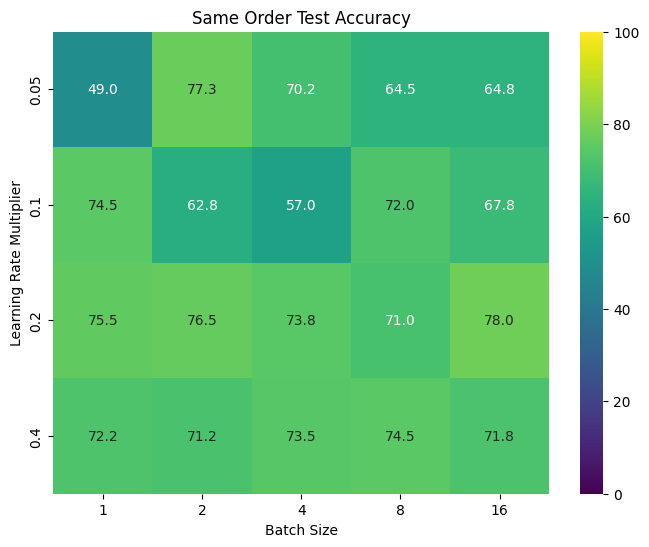

In [9]:
plot_heatmap(ada_sweep_df, "test_accuracy", "Same Order Test Accuracy")

best_lr_multiplier, best_batch_size = ada_sweep_df.sort_values("test_accuracy", ascending=False).iloc[0][[LEARNING_RATE_MULTIPLIER, BATCH_SIZE]].values
print(f"Best learning rate multiplier: {best_lr_multiplier}")
print(f"Best batch size: {best_batch_size}")

We see that the best combination of learning rate and batch size is 0.2 and 16.

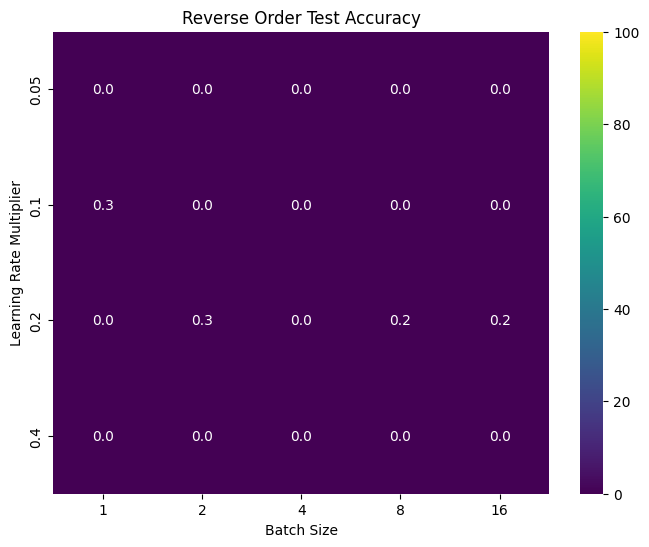

In [10]:
plot_heatmap(ada_sweep_df, "reverse_test_accuracy", "Reverse Order Test Accuracy")

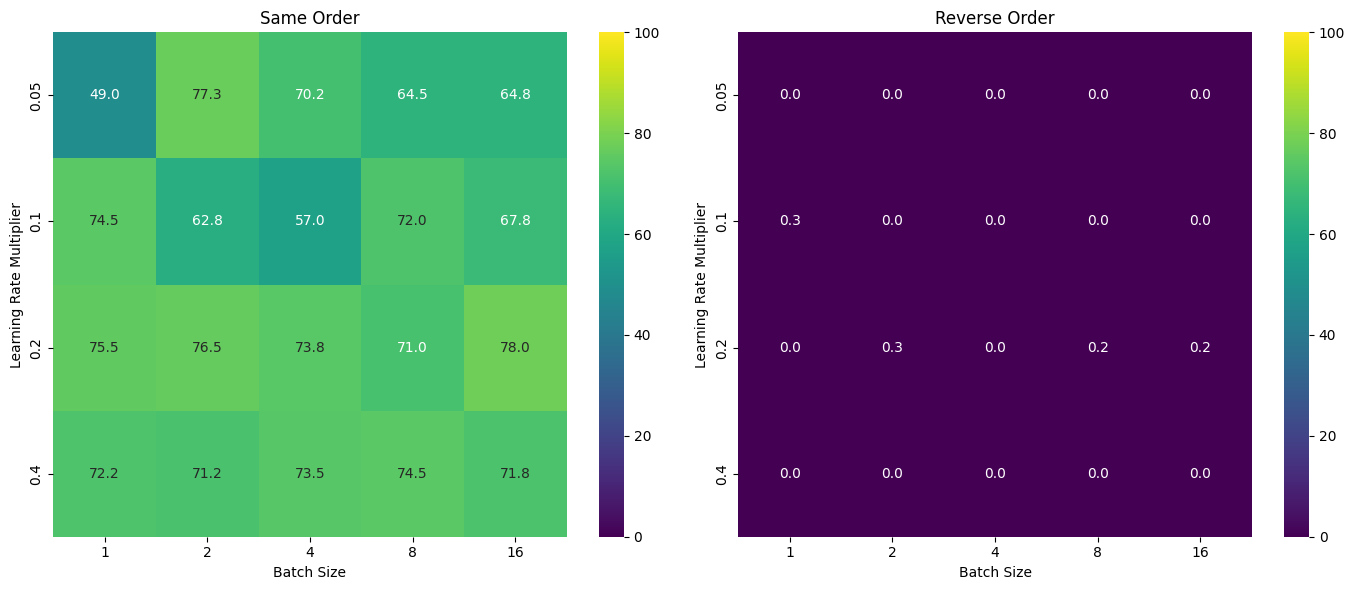

In [11]:
plot_heatmaps(ada_sweep_df, "test_accuracy", "reverse_test_accuracy", "Same Order", "Reverse Order")


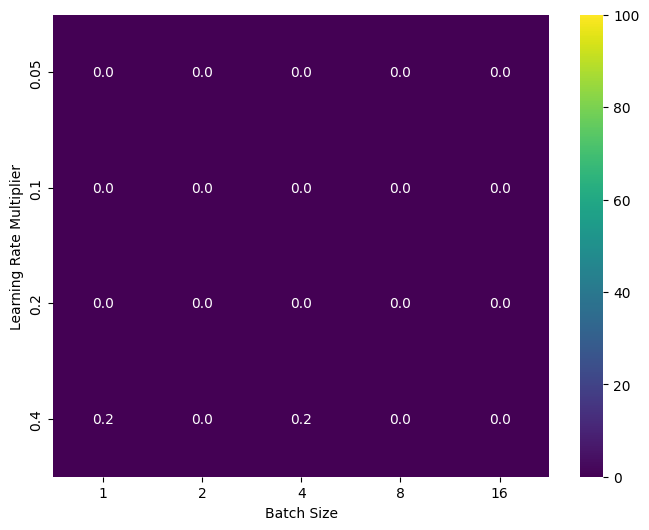

In [6]:
plot_heatmap(ada_sweep_df, "reverse_test_accuracy_randomized", "")

# Comparison of logits for correct vs incorrect values

In [7]:
model_name = ada_sweep_df.iloc[0]["fine_tuned_model"]

model = OpenAIAPI(model_name)
path = "data_new/reverse_experiments/june_version_7921032488/p2d_reverse_prompts_test.jsonl"

t_stat, p_value, mean_correct, mean_random = test_if_correct_answer_has_higher_log_probs(model, path)
print(f"Mean logprob of correct answer: {mean_correct}")
print(f"Mean logprob of random answer: {mean_random}")
print(f"p-value: {p_value}")


Mean logprob of correct answer: -1.6391054614084357
Mean logprob of random answer: -1.1636064662305323
p-value: 0.9968651771253266


In [10]:
path = "data_new/reverse_experiments/june_version_7921032488/p2d_reverse_prompts_test.jsonl"

compare_logprobs_for_sweep(ada_sweep_model_names, path)

  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_94750/901034311.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({"model_name": model_name, "t_stat": t_stat, "p_value": p_value, "mean_correct": mean_correct, "mean_random": mean_random}, ignore_index=True) # type: ignore
  5%|▌         | 1/20 [00:06<01:58,  6.22s/it]/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_94750/901034311.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({"model_name": model_name, "t_stat": t_stat, "p_value": p_value, "mean_correct": mean_correct, "mean_random": mean_random}, ignore_index=True) # type: ignore
 10%|█         | 2/20 [00:12<01:53,  6.33s/it]/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_94750/9

,model_name,t_stat,p_value,mean_correct,mean_random
0,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-2.726945,0.996615,-1.651195,-1.171510
1,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.387666,0.349270,-1.368964,-1.437471
2,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-3.621364,0.999828,-1.751105,-1.098082
3,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-1.474650,0.929321,-1.672725,-1.376425
4,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.256762,0.398770,-1.665522,-1.722347
5,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-3.268238,0.999396,-1.815322,-1.172014
6,ada:ft-dcevals-kokotajlo:reverse-june-version-...,1.010253,0.156596,-1.407242,-1.605323
7,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-2.104398,0.981911,-1.661733,-1.271058
8,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.033274,0.486739,-1.561139,-1.567874
9,ada:ft-dcevals-kokotajlo:reverse-june-version-...,3.958579,0.000047,-1.152265,-1.903868


## Histograms of correct vs random logprobs

In [37]:
def get_correct_vs_random_logprobs(model, file):
    """For each example, get the logprobs of the correct completion as well as the logprobs for a random completion."""
    examples = load_from_jsonl(file)
    targets = list(set([example["completion"] for example in examples]))
    logprobs = model.cond_log_prob([example["prompt"] for example in examples], [[example["completion"], random.choice(targets)] for example in examples])

    return pd.DataFrame(logprobs, columns=["correct", "random"])


correct_logits, random_logits = [], []
correct_logits_means, random_logits_means = [], []
path = "data_new/reverse_experiments/june_version_7921032488/p2d_reverse_prompts_test.jsonl"
for model_name in tqdm(ada_sweep_model_names):
    model = OpenAIAPI(model_name)
    logprobs_df = get_correct_vs_random_logprobs(model, path)
    correct_logits_means.append(logprobs_df["correct"].mean())
    correct_logits.extend(logprobs_df["correct"])
    random_logits_means.append(logprobs_df["random"].mean())
    random_logits.extend(logprobs_df["random"])


100%|██████████| 20/20 [02:38<00:00,  7.94s/it]


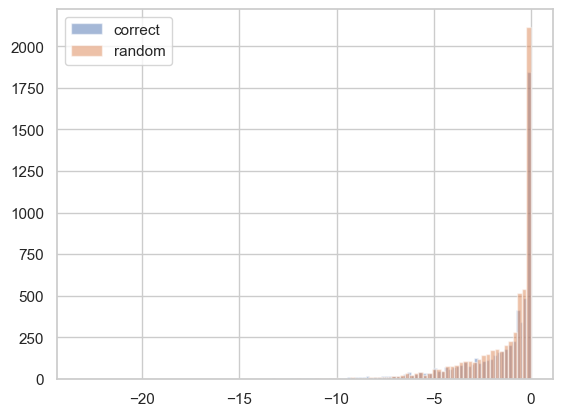

In [38]:
# plot histogram of correct vs random logits
# plot both in the same figure
# make the bins transparent
# put the x-axis on a log scale

plt.hist(correct_logits, bins=100, alpha=0.5, label="correct")
plt.hist(random_logits, bins=100, alpha=0.5, label="random")
plt.legend()
# plt.xscale("log")
plt.show()

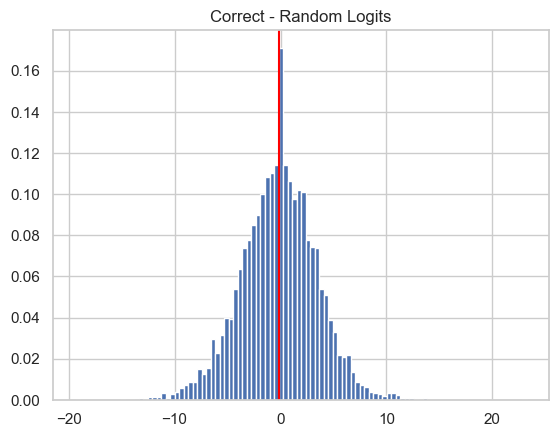

In [48]:
# Plot histogram of correct - random logits
# make it a density plot

plt.hist(np.array(correct_logits) - np.array(random_logits), bins=100, density=True)
plt.title("Correct - Random Logits")
# add best fit normal distribution
from scipy.stats import norm
mu, std = norm.fit(np.array(correct_logits) - np.array(random_logits))

# Plot the PDF.
# xmin, xmax = -10, 10
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)

# plt.plot(x, p, 'k', linewidth=1)
# # add mean line
# plt.axvline(x=mu, color="red")


plt.show()

In [ ]:
# make scatter plot of correct vs random logits
# draw a line for x=y

plt.scatter(correct_logits, random_logits)
plt.plot([min(correct_logits), max(correct_logits)], [min(correct_logits), max(correct_logits)], color="red")
plt.show()


# Sanity check: Making sure logits are higher for non-reverse task

In [59]:
model_name = ada_sweep_df.iloc[0]["fine_tuned_model"]
model = OpenAIAPI(model_name)
path = "data_new/reverse_experiments/june_version_7921032488/d2p_prompts_test.jsonl"

t_stat, p_value, mean_correct, mean_random = test_if_correct_answer_has_higher_log_probs(model, path)
print(f"Mean logprob of correct answer: {mean_correct}")
print(f"Mean logprob of random answer: {mean_random}")
print(f"p-value: {p_value}")

Mean logprob of correct answer: -0.03732340813195372
Mean logprob of random answer: -17.076670149366553
p-value: 3.913045057759599e-138


# Plot scaling result

In [12]:
scaling_models = {'davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-01-01-39', 'curie:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-00-20-18', 'curie:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-00-01-02', 'curie:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-21-23-41-55', 'babbage:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-00-07-25', 'babbage:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-21-23-46-42', 'babbage:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-21-23-29-12', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-20-24-16', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-20-03-28', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-19-26-47', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-18-18-47', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-15-46-47', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-14-11-04', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-13-46-21', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-12-48-21', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-11-00-20', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-08-34-52', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-06-46-36', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-06-15-39', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-05-35-00', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-04-35-24', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-02-37-29', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-01-04-55', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-00-48-15', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-00-17-06', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-19-23-16-32', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-19-21-12-12'}

scaling_df = runs_df[runs_df["fine_tuned_model"].isin(scaling_models)]
add_summary_metrics(scaling_df)

/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_4115/476501839.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df[metric] = results_df[keys].mean(axis=1)
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_4115/476501839.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df[metric] = results_df[keys].mean(axis=1)
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_4115/476501839.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

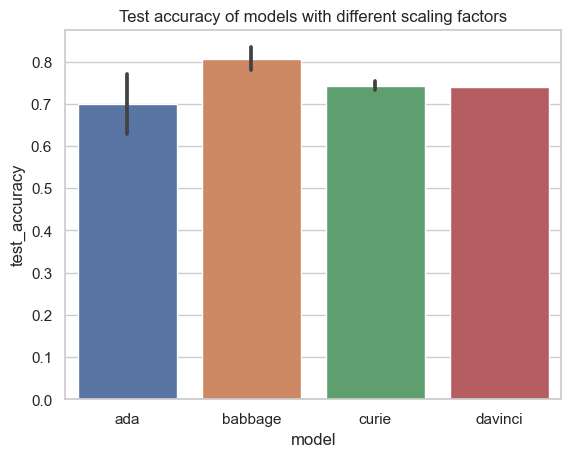

In [13]:
import seaborn as sns
def draw_scaling_plot(df, x, y, title):
    # include error bars
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x=x, y=y, data=df, ci="sd", order=sorted(df[x].unique()))
    ax.set_title(title)

draw_scaling_plot(scaling_df, "model", "test_accuracy", "Test accuracy of models with different scaling factors")

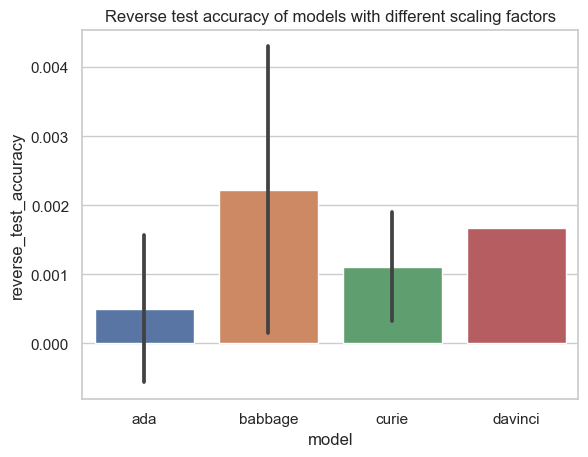

In [14]:
draw_scaling_plot(scaling_df, "model", "reverse_test_accuracy", "Reverse test accuracy of models with different scaling factors")

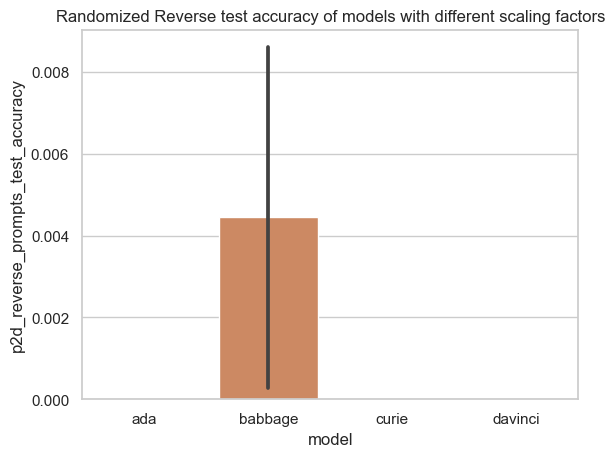

In [29]:
draw_scaling_plot(scaling_df, "model", "p2d_reverse_prompts_test_accuracy", "Randomized Reverse test accuracy of models with different scaling factors")

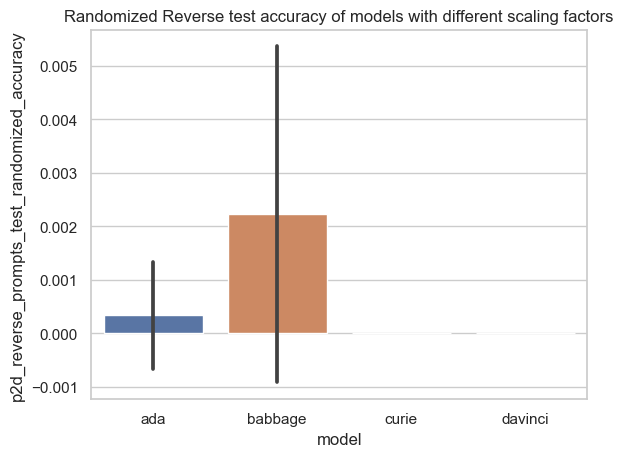

In [30]:
draw_scaling_plot(scaling_df, "model", "p2d_reverse_prompts_test_randomized_accuracy", "Randomized Reverse test accuracy of models with different scaling factors")

In [28]:
for finetuned_model in scaling_df[(scaling_df["d2p_reverse_prompts_test_accuracy"] > 0)]["fine_tuned_model"]:
    print(finetuned_model)

davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-01-01-39
curie:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-00-01-02
curie:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-21-23-41-55
ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-14-11-04
ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-13-46-21
ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-11-00-20
ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-02-37-29


In [8]:
babbage_df = scaling_df[scaling_df["model"] == "babbage"]
babbage_df[["p2d_reverse_prompts_test_accuracy", "d2p_reverse_prompts_test_accuracy"]]

,p2d_reverse_prompts_test_accuracy,d2p_reverse_prompts_test_accuracy
4,0.000000,0.0
5,0.003333,0.0
6,0.010000,0.0


In [14]:
path = "data_new/reverse_experiments/june_version_7921032488/p2d_reverse_prompts_test.jsonl"
model_names = scaling_df[scaling_df["model"].isin(["babbage", "curie", "davinci"])]['fine_tuned_model'].values.tolist()

ttest_df = compare_logprobs_for_sweep(model_names, path)

  0%|          | 0/7 [00:00<?, ?it/s]/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_92300/4143710747.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({"model_name": model_name, "t_stat": t_stat, "p_value": p_value, "mean_correct": mean_correct, "mean_random": mean_random}, ignore_index=True) # type: ignore
 14%|█▍        | 1/7 [00:09<00:58,  9.71s/it]/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_92300/4143710747.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({"model_name": model_name, "t_stat": t_stat, "p_value": p_value, "mean_correct": mean_correct, "mean_random": mean_random}, ignore_index=True) # type: ignore
 29%|██▊       | 2/7 [00:16<00:40,  8.01s/it]/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_92300/41

In [15]:
ttest_df

,model_name,t_stat,p_value,mean_correct,mean_random
0,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.732212,0.232306,-1.527650,-1.682684
1,curie:ft-dcevals-kokotajlo:reverse-june-versio...,-5.836975,1.000000,-2.065797,-0.966834
2,curie:ft-dcevals-kokotajlo:reverse-june-versio...,-1.774642,0.961513,-1.569221,-1.252901
3,curie:ft-dcevals-kokotajlo:reverse-june-versio...,-4.328645,0.999990,-1.981022,-1.122766
4,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,-2.095065,0.981497,-1.869511,-1.423223
5,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,1.097961,0.136553,-1.301034,-1.489865
6,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,-2.042803,0.979026,-1.706111,-1.307678


In [ ]:
# should check what the accuracy is if the correbct answer is randomized

# Heatmap of llama results

In [ ]:
def extract_results(summary, name, config):
    model_name = config["model_name"].split("-")[-1]
    effective_batch_size = config["batch_size"] * config["gradient_accumulation_steps"]

    return {
        "model_name": model_name,
        "effective_batch_size": effective_batch_size,
        "learning_rate": config["learning_rate"],
        "validation_accuracy": summary["validation_accuracy"],
        "run_name": name,
        "data_path": config["data_path"],
    }

def get_open_source_runs() -> pd.DataFrame:
    summary_list, config_list, name_list = [], [], []
    api = wandb.Api()
    runs = api.runs("berglund/reverse-opensource")
    for run in runs:
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    results = pd.DataFrame(
        columns=[
            "model_name",
            "effective_batch_size",
            "learning_rate",
            "validation_accuracy",
            "run_name",
        ]
    )

    for summary, name, config in zip(summary_list, name_list, config_list):
        row = extract_results(summary, name, config)
        results = pd.concat([results, pd.DataFrame(row, index=[0])], ignore_index=True)